---
title: "텍스트마이닝"
author: "박성일"
date: "2024-07-30"
description: "텍스트마이닝을 해보아요"
image: "data/text_mining_thumbnail.png"
format: 
  html:
    toc: true

---

# 텍스트마이닝

텍스트 마이닝이란 대량의 텍스트 데이터에서 유용한 정보와 패턴을 추출하고 분석하는 과정이다.

전체 데이터는 `문장`컬럼이 어떤 대상을 혐오하는지에 대한 데이터이고,<br> 분류 분석을 통해 문장의 어떤 특징이 분류 결과에 가중치를 주었는지를 보고자 한다.

## 1. 텍스트 데이터의 전처리
### 1-1. 토큰화(Tokenize)

**토큰화**란 텍스트 데이터 처리에서 중요한 첫 단계로 텍스트를 분석하기 위해 작은 단위로 분할하는 과정을 의미한다.

토큰화의 목적은 텍스트를 단어, 문장, 구절 등 의미 있는 작은 단위로 나누어 기계가 이해할 수 있게 하는 것이다.


In [99]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_data = 'data/unsmile_train_v1.0.tsv'
train = pd.read_csv(train_data, delimiter = '\t')

test_data = 'data/unsmile_valid_v1.0.tsv'
test = pd.read_csv(test_data, delimiter = '\t')
train.head()

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


`ntlk`는 자연어 처리에 사용되는 패키지이고, `word_tokenize`는 텍스트를 단어 단위로 분할하는데 사용된다.

`punkt`는 `ntlk`에서 제공되는 패키지로, 텍스트를 토큰화하는데 필요한 알고리즘과 데이터가 있다.

In [100]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sungil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

*"넌 바라는게 너무 많아, 우리 헤어져"* 를 `word_tokenize()`로 토큰화하면 다음과 같다.

In [102]:
words = word_tokenize("넌 바라는게 너무 많아, 우리 헤어져")
words

['넌', '바라는게', '너무', '많아', ',', '우리', '헤어져']

전체 문장 토큰화

In [116]:
clean_token = []
for i in train['문장']:
    for j in word_tokenize(i):
        clean_token.append(j)
# 9개 값만 뽑아보기
clean_token[:9]

['일안하는', '시간은', '쉬고싶어서', '그런게', '아닐까', '아동성범죄와', '페도버는', '기록바', '끊어져']

토큰화된 텍스트 데이터에서 어떤 단어가 많이 나왔는지, 빈도를 세어 보고, 워드클라우드를 그려보았다.

`Counter()` : 딕셔너리 형식으로 리스트 내의 값의 빈도 출력

In [117]:
from collections import Counter
count = Counter(clean_token)
# 상위 15개 값만 추출
count.most_common(15)

[('?', 3815),
 ('.', 3416),
 ('!', 2066),
 (',', 1174),
 ('..', 979),
 ('...', 905),
 ('다', 667),
 ('진짜', 543),
 ('왜', 540),
 ('ㅋㅋ', 435),
 ('존나', 376),
 ('그냥', 372),
 ('더', 368),
 ('ㅋㅋㅋ', 363),
 ('>', 296)]

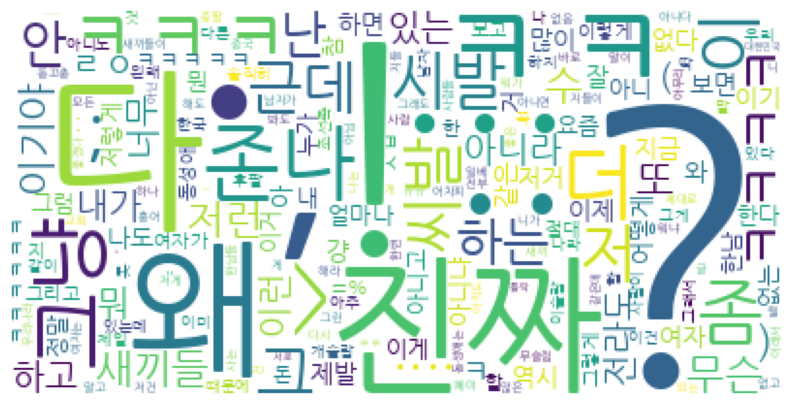

In [118]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

wc = WordCloud(background_color = 'white', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
wc.generate_from_frequencies(count)

plt.imshow(wc)
plt.axis('off')
plt.show()

**빈도를 세본 결과, 1글자(왜,다,더,좀..)와 "ㅋㅋㅋ"등 큰 의미가 없는 단어가 있었다.**

### 1-2. 텍스트 전처리 (정규표현식과 텍스트 필터링)

한글자 단어와, 기호, "ㅋㅋㅋ" 등 큰 의미가 없는 단어를 제거하면, 

텍스트 데이터의 **노이즈를 줄이고, 더 정확하고 유용한 정보를 추출**할 수 있다.

---

텍스트 데이터의 전처리를 위해 `re`패키지를 사용한다.

- `re`패키지는 정규표현식을 사용하여 문자열을 조작하는 기능을 제공한다.

- `p = re.compile(pattern)`은 토큰에 **pattern**이 포함되어 있는지를 출력한다(True/False)

- `"[ㅋㅎㄷㅇ~!?.\\-ㅡ0-9a-z]+"` 패턴은 **ㅋ, ㅎ, ㄷ, ㅇ, ~, !, ?, ., -, ㅡ, 숫자(0~9), 소문자 영어(a~z)** 를 의미한다.

---

1. 반복문을 사용하여 공백 기준으로 토큰화

2. 토큰이 한 글자거나 pattern에 해당하면 스킵

3. 스킵되지 않은 토큰들을 다시 문장으로 만들어 train clean 리스트에 넣기

In [21]:
import re
p = re.compile("[ㅋㅎㄷㅇ~!?.\\-ㅡ0-9a-z]+")
train_clean = [] 

for doc in train['문장']:
    temp = []
    for token in doc.split(" "):
        if len(token) < 2:
            continue
        if p.search(token):
            continue

        temp.append(token)
    train_clean.append(" ".join(temp))

# 테스트 데이터
test_clean = []

for doc in test['문장']:
    temp = []
    for token in doc.split(" "):
        if len(token) < 2:
            continue
        if p.search(token):
            continue

        temp.append(token)
    test_clean.append(" ".join(temp))

텍스트 데이터가 더 깔끔해진 것을 확인할 수 있다. 

In [22]:
train_clean[:6]

['일안하는 시간은 쉬고싶어서 그런게 아닐까',
 '아동성범죄와 페도버는 기록바 끊어져 영원히 고통 무슬림 IQ 떨어지고 출산 위험은',
 '루나 솔로앨범 나왔을 때부터 머모 기운 있었음 진짜 띵곡임 들어보셈"',
 '홍팍에도 어버이연합인가 보내요 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽에서 고소',
 '아놔 여기 댓들은 여자들이 김치녀라고 먼저 여자들은 심하게 이렇게 내가 둘다 나쁜 이상도 이하도 아닌데',
 '고향가서 피방가면 동네 부럴 친구들이랑은 거르는 없이 이야기하니까 말하게 되더라 당연히 키보드를 치거나 그러지는 않는데 말하는게 많이 거칠어지긴 반성해야겠네']

### 1-3. 텍스트 전처리 (형태소 단위 분리)

한국어 문법 특성상 텍스트 데이터를 공백으로 나누는 것보다, **형태소 단위**로 나누면 텍스트의 의미를 더 정밀하게 분석할 수 있다. 

---

형태소 분리를 하기 위해 `konlpy`패키지를 사용한다.

`konlpy` 패키지에는 `Hannanum`, `Kkma`, `Komoran`, `Mecab`, `Okt`등의 형태소 분석기가 있다.

`morphs()`함수는 문장을 형태소 단위로 나누어준다. 

다음은 형태소 단위 분리의 예시이다.

In [23]:
from konlpy.tag import Okt, Kkma
okt = Okt()

t_1 = "아버지가 방에 들어가신다"
t_2 = "아버지 가방에 들어가신다"

print(okt.morphs(t_1))
print(okt.morphs(t_2))

['아버지', '가', '방', '에', '들어가신다']
['아버지', '가방', '에', '들어가신다']


형태소 단위 분리에 앞서 `emoji`패키지를 사용해 문장 내의 이모지를 제거하였다.

In [24]:
import emoji
train_clean = [emoji.replace_emoji(tc) for tc in train_clean]
test_clean = [emoji.replace_emoji(tc) for tc in test_clean]

`Kkma`형태소 분석기의 `morphs()` 함수를 사용하여 문장을 형태소로 분리, 리스트 형태로 저장.

train : test = 2700 : 1000 으로 사용

In [25]:
from tqdm import tqdm

kkma = Kkma()
konlpy_morphs_train = []
for doc in tqdm(train_clean[:2700]):
  rs = kkma.morphs(doc)
  konlpy_morphs_train.append(" ".join(rs))

# 테스트트
konlpy_morphs_test = []
for doc in tqdm(test_clean[:1000]): 
  rs = kkma.morphs(doc)
  konlpy_morphs_test.append(" ".join(rs))

  0%|          | 0/2700 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 81.21it/s]


In [26]:
konlpy_morphs_train[:6]

['일 안 하 는 시간 은 쉬 고 싶 어서 그러 ㄴ 것 이 아니 ㄹ까',
 '아동 성 범죄 와 페도버 는 기록 바 끊어지 어 영원히 고통 무슬림 IQ 떨어지 고 출산 위험 은',
 '루 나 솔로 앨범 나오 았 을 때 부터 머 모 기운 있 었 음 진짜 띵 곡 임 듣 어 보셈 "',
 '홍팍에 도 어버이 연합 이 ㄴ가 보 내요 이러 ㄴ 뎃 글 있 는데 이거 어버이 연합 측 에 신고 하면 그쪽 에서 고소',
 '아 아 노 아 여기 댓 듣 은 여자 들 이 김치 녀 라고 먼저 여자 들 은 심하 게 이렇 게 내가 둘 다 나쁘 ㄴ 이상 도 이하 도 아니 ㄴ데',
 '고향 가 아서 피 방가 이 면 동네 부 럴 치 ㄴ 구들 이랑 은 거르 는 없이 이야기 하 니까 말하 게 되 더라 당연히 키보드 를 치 거나 그러 지 는 않 는데 말하 는 것 이 많이 거칠어지 기 는 반성 하 어야 겠네']

## 2. 텍스트 데이터 변환

kkma 형태소 분석기로 분리한 텍스트 데이터를, 모델에 적용하기 위해 숫자 형태로 바꾸어준다.

---
### 2-1. BOW (Bag-of-Words)

**BOW(Bag-of-Words)** 는 텍스트 데이터에서 각 단어의 빈도를 세어 숫자형 벡터로 변환하는 방법이다.

`CountVectorizer`는 BOW방식으로 텍스트 데이터를 숫자형 피처 벡터로 변환해주는 `Scikit-learn`의 클래스이다. 

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

sample_text = ["나는 오늘 치킨을 먹을거야",
               "너는 오늘 저녁에 무엇을 먹을거니",
               "나는 오늘 아침에 운동을 하고 왔어",
               "어제 저녁에 운동을 했더니 배가 고프다"]

sample_bow = CountVectorizer()
sample_bow.fit(sample_text)

CountVectorizer()

예시 문장으로 만든 단어 사전 `sample_bow`는 다음과 같다.

In [28]:
sample_bow.vocabulary_

{'나는': 1,
 '오늘': 9,
 '치킨을': 13,
 '먹을거야': 4,
 '너는': 2,
 '저녁에': 12,
 '무엇을': 5,
 '먹을거니': 3,
 '아침에': 7,
 '운동을': 11,
 '하고': 14,
 '왔어': 10,
 '어제': 8,
 '했더니': 15,
 '배가': 6,
 '고프다': 0}

단어사전 16글자에서 어떤 단어가 등장했는지를 1로 표현하는 숫자 벡터이다.

데이터프레임으로 변환한 단어사전과 비교해보면 이해할 수 있다.

In [29]:
pd.DataFrame([[i,j] for i,j in sample_bow.vocabulary_.items()], columns=["단어","인덱스"]).sort_values("인덱스").reset_index(drop = True).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
단어,고프다,나는,너는,먹을거니,먹을거야,무엇을,배가,아침에,어제,오늘,왔어,운동을,저녁에,치킨을,하고,했더니
인덱스,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


In [30]:
rs = sample_bow.transform(sample_text)
rs.toarray()

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]])

### 2-2. TF-IDF (Term Frequency-Inverse Document Frequency)

**TF-IDF**는 텍스트를 숫자형 벡터로 변환하는 방법 중 하나로, 단어의 빈도(Term Frequency)에 가중치를 부여하는 방법이다.

단순히 단어의 빈도만을 사용하는 Bag-of-Words 모델보다 **더 유용한 정보를 제공**한다.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

sample_text = ["나는 오늘 치킨을 먹을거야",
               "너는 오늘 저녁에 무엇을 먹을거니",
               "나는 오늘 아침에 운동을 하고 왔어",
               "어제 저녁에 운동을 했더니 배가 고프다"]

tfidf_vectorizer = TfidfVectorizer()

tfidf_vector = tfidf_vectorizer.fit_transform(sample_text)

In [32]:
tfidf_vectorizer.vocabulary_

{'나는': 1,
 '오늘': 9,
 '치킨을': 13,
 '먹을거야': 4,
 '너는': 2,
 '저녁에': 12,
 '무엇을': 5,
 '먹을거니': 3,
 '아침에': 7,
 '운동을': 11,
 '하고': 14,
 '왔어': 10,
 '어제': 8,
 '했더니': 15,
 '배가': 6,
 '고프다': 0}

단어사전에 해당하는 인덱스가 0,1 이 아닌 가중치가 부여됨을 확인할 수 있다.

In [33]:
pd.DataFrame([[i,j] for i,j in tfidf_vectorizer.vocabulary_.items()], columns=["단어","인덱스"]).sort_values("인덱스").reset_index(drop = True).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
단어,고프다,나는,너는,먹을거니,먹을거야,무엇을,배가,아침에,어제,오늘,왔어,운동을,저녁에,치킨을,하고,했더니
인덱스,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


In [34]:
print(tfidf_vector.toarray())

[[0.         0.4530051  0.         0.         0.57457953 0.
  0.         0.         0.         0.36674667 0.         0.
  0.         0.57457953 0.         0.        ]
 [0.         0.         0.49819711 0.49819711 0.         0.49819711
  0.         0.         0.         0.31799276 0.         0.
  0.39278432 0.         0.         0.        ]
 [0.         0.36559366 0.         0.         0.         0.
  0.         0.46370919 0.         0.29597957 0.46370919 0.36559366
  0.         0.         0.46370919 0.        ]
 [0.43671931 0.         0.         0.         0.         0.
  0.43671931 0.         0.43671931 0.         0.         0.34431452
  0.34431452 0.         0.         0.43671931]]


### 2-3. SentenceTransformer

**SentenceTransformer**는 Transformer(영화아님, 딥러닝 모델) 기반의 사전 학습된 모델을 통하여 문장을 고차원 숫자 벡터로 변환한다.

TF-IDF는 단어의 빈도에 가중치를 부여하는 방식으로, 문맥을 고려하지 못한다. ex)똥맛 카레, 카레맛 똥

**SentenceTransformer**는 Transformer기반 모델을 통해 문맥을 고려하여 문장 내의 단어 순서와 의미를 반영할 수 있다.

차원수의 차이 때문에 단순한 텍스트 분석인지, 복잡한 자연어처리 작업인지에 따라 사용하면 된다.

[사용모델 paraphrase-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2)

In [35]:
from sentence_transformers import SentenceTransformer

sample_text = ["나는 오늘 치킨을 먹을거야",
               "너는 오늘 저녁에 무엇을 먹을거니",
               "나는 오늘 아침에 운동을 하고 왔어",
               "어제 저녁에 운동을 했더니 배가 고프다"]

sample_embedding = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = sample_embedding.encode(sample_text)
embeddings

2024-07-30 17:28:40.050781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 17:28:40.051695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 17:28:40.054281: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 17:28:40.061751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 17:28:40.074227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

array([[-0.0055915 ,  0.58696157,  0.12903269, ..., -0.5404554 ,
         0.9031779 ,  0.508091  ],
       [ 0.14074272,  0.4005823 ,  0.07539973, ..., -0.30134737,
         0.9708954 ,  0.6109679 ],
       [ 0.26552293,  0.540008  ,  0.1140722 , ..., -0.55974346,
         0.8789244 ,  0.6666612 ],
       [ 0.23060054,  0.45907632,  0.08265256, ..., -0.41313243,
         1.0001894 ,  0.5942588 ]], dtype=float32)

4 * 384의 행렬으로 변환되었다. (TF-IDF보다 큼)

In [36]:
embeddings.shape

(4, 384)

## 3. 모델 적용 (분류, Classification)


분류 모델을 사용하여 숫자 벡터로 바꾼 텍스트 데이터가 무얼 혐오하는지 분류한다.



앞서 사용한 텍스트 데이터의 변환 중 BOW(CountVectorizer), TF-IDF(TfidfVectorizer) 방식을 사용한다.

파라미터의 의미는 다음과 같다.

- `stop_words=` : 숫자 벡터로 변환하는 과정에서 무시할 단어의 리스트

- `ngram_range=` : 단어 묶음의 범위
    - ngram_range=1이면 ["오늘", "치킨을"]
    - ngram_range=2 면 ["오늘 치킨을"]
    - (1,2)는 ["오늘", "치킨을", "오늘 치킨을"] 이다

- `max_df=` 특정 단어가 너무 자주 등장하면 무시하는 기능 (0.7 -> 전체 문서의 70%이상이면 무시)

- `min_df=` 특정 단어가 너무 적게 등장하면 무시하는 기능 (10 -> 10개 이하는 무시)

### 3-1. 데이터 변환 적용

In [37]:
unsmile_bow = CountVectorizer(stop_words=["으로","을","를","은","이다"],
                              ngram_range = (1,2),
                              max_df = 0.7, min_df = 10)
unsmile_tfidf = TfidfVectorizer(stop_words=["으로","을","를","은","이다"],
                              ngram_range = (1,2),
                              max_df = 0.7, min_df = 10)

앞서 `konlpy.Kkma`를 사용해서 형태소 단위로 나는 데이터를 사용한다.

`fit_transform()`메소드로 train 데이터를 학습하고, 변환하고

`transform()` 메소드로 test 데이터를 변환한다.

In [38]:
X_train_bow = unsmile_bow.fit_transform(konlpy_morphs_train)
X_test_bow = unsmile_bow.transform(konlpy_morphs_test)

X_train_tfidf = unsmile_tfidf.fit_transform(konlpy_morphs_train)
X_test_tfidf = unsmile_tfidf.transform(konlpy_morphs_test)

**y**는 어떤 대상을 혐오한지의 인덱스 값이다. 

In [39]:
for i,j in enumerate(train.loc[:, "여성/가족":"clean"].columns):
    print(f"인덱스[{i}] : {j}")

인덱스[0] : 여성/가족
인덱스[1] : 남성
인덱스[2] : 성소수자
인덱스[3] : 인종/국적
인덱스[4] : 연령
인덱스[5] : 지역
인덱스[6] : 종교
인덱스[7] : 기타 혐오
인덱스[8] : 악플/욕설
인덱스[9] : clean


In [40]:
y_train = train.loc[:, "여성/가족":"clean"].values.argmax(axis=1)
y_test = test.loc[:, "여성/가족":"clean"].values.argmax(axis=1)
y_train = y_train[:2700]
y_test = y_test[:1000]

### 3-2. 모델 적용 (로지스틱 회귀 분석)

#### 3-2-1. BOW 방식

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logistic = LogisticRegression()

# 학습
logistic.fit(X_train_bow, y_train)

# 예측
bow_pred = logistic.predict(X_test_bow)

# 분류 평가지표
print(classification_report(bow_pred,y_test))

              precision    recall  f1-score   support

           0       0.35      0.49      0.41        78
           1       0.59      0.69      0.64        65
           2       0.51      0.64      0.57        59
           3       0.43      0.73      0.54        66
           4       0.19      1.00      0.32         6
           5       0.55      0.76      0.64        42
           6       0.58      0.81      0.67        37
           7       0.00      0.00      0.00         5
           8       0.38      0.34      0.36       218
           9       0.74      0.45      0.56       424

    accuracy                           0.50      1000
   macro avg       0.43      0.59      0.47      1000
weighted avg       0.57      0.50      0.51      1000



#### 3-2-2. TF-IDF 방식

In [42]:
logistic = LogisticRegression()

# 학습
logistic.fit(X_train_tfidf, y_train)

# 예측
tfidf_pred = logistic.predict(X_test_tfidf)

# 분류 평가지표
print(classification_report(tfidf_pred,y_test))

              precision    recall  f1-score   support

           0       0.33      0.55      0.41        65
           1       0.59      0.70      0.64        64
           2       0.49      0.68      0.57        53
           3       0.38      0.74      0.50        57
           4       0.19      1.00      0.32         6
           5       0.50      0.83      0.62        35
           6       0.62      0.84      0.71        38
           7       0.00      0.00      0.00         0
           8       0.41      0.35      0.38       236
           9       0.76      0.44      0.56       446

    accuracy                           0.50      1000
   macro avg       0.43      0.61      0.47      1000
weighted avg       0.58      0.50      0.51      1000



#### 3-2-3. SentenceTransformer 방식

`SentenceTransformer`방식은 시간이 오래 걸려 사전 처리된 데이터를 불러와 사용하였다.

In [43]:
import pickle
## pkl 파일 불러오기기
test_pkl_path = "/home/sungil/DXschool/data/X_test_setence_transformer3.pkl"
train_pkl_path = "/home/sungil/DXschool/data/X_train_setence_transformer3.pkl"

with open(train_pkl_path,"rb") as f:
    X_train_embedding = pickle.load(f)

with open(test_pkl_path,"rb") as f:
    X_test_embedding = pickle.load(f)

In [44]:
X_train_embedding = pd.DataFrame(X_train_embedding[:2700])
X_test_embedding = pd.DataFrame(X_test_embedding[:1000])
# 차원 수
X_train_embedding.shape, X_test_embedding.shape

((2700, 768), (1000, 768))

In [45]:
logistic = LogisticRegression()

# 학습
logistic.fit(X_train_embedding, y_train)

# 예측
embedding_pred = logistic.predict(X_test_embedding)

# 분류 평가지표
print(classification_report(embedding_pred,y_test))

              precision    recall  f1-score   support

           0       0.59      0.60      0.60       106
           1       0.63      0.55      0.59        88
           2       0.70      0.66      0.68        79
           3       0.57      0.61      0.59       103
           4       0.38      0.52      0.44        23
           5       0.60      0.66      0.63        53
           6       0.62      0.65      0.63        49
           7       0.07      0.15      0.09        13
           8       0.52      0.47      0.49       219
           9       0.60      0.58      0.59       267

    accuracy                           0.57      1000
   macro avg       0.53      0.55      0.53      1000
weighted avg       0.58      0.57      0.57      1000



## 4. 성능 지표 해석

![image-2.png](data/classification_report.png)

분류 결과 

- acurracy (정확도) : 0.5, 0.5, 0.57

- precision (정밀도) : 0.43, 0.43, 0.53

- recall (재현률) : 0.59, 0.61, 0.55

세 모델 모두 분류 성능이 좋지 않다는걸 확인할 수 있다.

train 데이터의 **클래스 불균형**(4번,7번 클래스가 특히 부족)이 있었다.

클래스 불균형 문제를 해결하거나, 하이퍼파라미터 튜닝, 다른 분류모델 사용, 다른 벡터화 기법 사용 등을 고려해봐야 한다.

## 5. 파이프라인 & 하이퍼파라미터 튜닝

전처리 과정을 묶고 최적의 파라미터 찾기



### 5-1. 파이프라인

텍스트 데이터를 숫자 벡터로 변환하고, 분류 모델을 평가하는 과정을 파이프라인을 통해 하나로 묶을 수 있다. 

`Pipeline([("이름1", 클래스1),("이름2", 클래스2)])`

다음 파이프라인은 형태소로 분리한 텍스트 데이터를 받아
- TF-IDF 방식 숫자형 벡터로 변환
- 로지스틱 회귀분석

을 진행한다.

In [46]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("tf_idf", TfidfVectorizer()),
        ("logi", LogisticRegression())
    ]
)

In [47]:
# 학습
pipeline.fit(konlpy_morphs_train,y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('logi', LogisticRegression())])

In [48]:
# 평가 (Accuracy)
pipeline.score(konlpy_morphs_test, y_test)

0.5

### 5-2. 하이퍼파라미터 튜닝

**하이퍼 파라미터**는 파라미터와 구분하여 사용자가 설정하는 값들을 모두 지칭한다.


`GridSearchCV`를 사용하여 최적의 하이퍼파라미터 조합을 찾아낸다.

숫자벡터 변환, 분류 모델 들어가는 하이파파라미터들의 조합은 아주 많다. 하나하나 하기엔 오래걸리니까 한다.


앞서 만든 파이프라인을 사용한다.

{"이름1__파라미터명1" : [파라미터1,파라미터2...],<br>
"이름1__파라미터명2" : [파라미터1,파라미터2...],<br>
"이름2__파라미터명1" : [파라미터1,파라미터2...]}

으로 작성하고 

`GridSearchCV(pipeline, grid_params, cv=3)`

- pipeline : 파이프라인
- grid_params : 파리미터들
- cv : Cross Validation




이건 Cross Validation(교차 검증)이다.

학습 데이터를 n개로 나눠서 n번 학습을 하고 자체 평가를 한다.

성능이 좋아지지만, 시간이 오래 걸린디.

![image.png](data/cross_validation.png)

Logistic Regression의 `C`파라미터는 규제 강도를 조절한다.

작을수록 규제가 강해지고 높을수록 약해진다.

- 규제가 강하면 과대적합을 방지하지만 **과소적합의 위험**이 있다.
- 규제가 약하면 과소적합을 방지하지만 **과대적합의 위험**이 있다.


In [49]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    "tf_idf__ngram_range" : [(1,1),(1,2),(1,3)],
    "tf_idf__max_df" : [0.5, 0.7, 0.8],
    "tf_idf__min_df" : [10, 20, 30],
    "logi__C" : [0.001, 0.1, 1, 10],
}

gridsearch = GridSearchCV(
    pipeline,
    grid_params,
    cv = 3
)

gridsearch.fit(konlpy_morphs_train,y_train) 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                                       ('logi', LogisticRegression())]),
             param_grid={'logi__C': [0.001, 0.1, 1, 10],
                         'tf_idf__max_df': [0.5, 0.7, 0.8],
                         'tf_idf__min_df': [10, 20, 30],
                         'tf_idf__ngram_range': [(1, 1), (1, 2), (1, 3)]})

총 조합 수는 
- n_gram_range 3개
- max_df 3개
- min_df 3개
- C 4개

으로 3x3x3x4 = 108개의 조합을 시도하고, `cv = 3`이기 때문에 각 조합마다 3번씩 학습, 총 324번을 학습한다. <br>시간이 오래 걸리는 이유이다.



`best_params_` 메소드를 통해 최적의 하이퍼파라미터를 출력한다.

`best_estimator_` 메소드로 최적의 파라미터로 학습한 모델을 불러온다.

In [50]:
gridsearch.best_params_

{'logi__C': 1,
 'tf_idf__max_df': 0.5,
 'tf_idf__min_df': 10,
 'tf_idf__ngram_range': (1, 1)}

In [51]:
best_model = gridsearch.best_estimator_

# 최적의 파라미터 모델 예측
best_param_pred = best_model.predict(konlpy_morphs_test)

# 예측 결과 지표
print(classification_report(y_test, best_param_pred))

              precision    recall  f1-score   support

           0       0.55      0.32      0.40       109
           1       0.71      0.62      0.66        76
           2       0.70      0.50      0.58        74
           3       0.76      0.38      0.51       111
           4       1.00      0.19      0.32        32
           5       0.83      0.52      0.64        58
           6       0.80      0.63      0.71        52
           7       0.00      0.00      0.00        30
           8       0.34      0.40      0.37       199
           9       0.44      0.76      0.56       259

    accuracy                           0.51      1000
   macro avg       0.61      0.43      0.47      1000
weighted avg       0.55      0.51      0.49      1000



0.51로 여전히 낮다.

## 6. 결과

어떤 단어가 분류에 가중치를 많이 주었는지 분류 모델을 통해 시각화 해보았다.

10 * 358 (혐오대상, 단어)의 가중치 행렬이다.

In [ ]:
weight = best_model.steps[1][1].coef_
weight.shape

(10, 358)

혐오 대상별 단어 시각화 함수

In [84]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import squarify

def plot_x(x):
    vocab = best_model.steps[0][1].vocabulary_
    weight = best_model.steps[1][1].coef_
    df = pd.DataFrame([vocab.keys(), vocab.values()]).T
    df.sort_values(by=1, inplace=True)

    df["W"] = weight[x]
    df.columns = ['단어', "인덱스", "가중치"]
    df.set_index('인덱스', inplace=True)

    print(df.sort_values('가중치', ascending=False).head())
    fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    font_name = fm.FontProperties(fname=fontpath, size=10).get_name()
    plt.rc('font', family=font_name)

    plt.rcParams['figure.figsize'] = (10,10)
    plt.rcParams['font.size'] = 15

    sizes = df.sort_values(by='가중치', ascending=False).head(30)['가중치']
    labels= df.sort_values(by='가중치', ascending=False).head(30)['단어']

    norm = matplotlib.colors.Normalize(vmin=min(sizes),vmax=max(sizes))
    colors = [matplotlib.cm.Reds(norm(value)) for value in sizes]

    squarify.plot(sizes, 10, 10, label=labels, color=colors,bar_kwargs=dict(linewidth=8, edgecolor="#eee"))
    plt.title("혐오에 활용되는 주요 키워드")
    plt.axis('off')
    plt.show()

In [82]:
for i,j in enumerate(train.loc[:, "여성/가족":"clean"].columns):
    print(f"인덱스[{i}] : {j}")

인덱스[0] : 여성/가족
인덱스[1] : 남성
인덱스[2] : 성소수자
인덱스[3] : 인종/국적
인덱스[4] : 연령
인덱스[5] : 지역
인덱스[6] : 종교
인덱스[7] : 기타 혐오
인덱스[8] : 악플/욕설
인덱스[9] : clean


### 6-1. 여성/가족

     단어       가중치
인덱스              
347  한남  6.890850
281  자지  3.586034
93   댕이  3.065344
69   냄져  3.052125
253  이기  2.174341


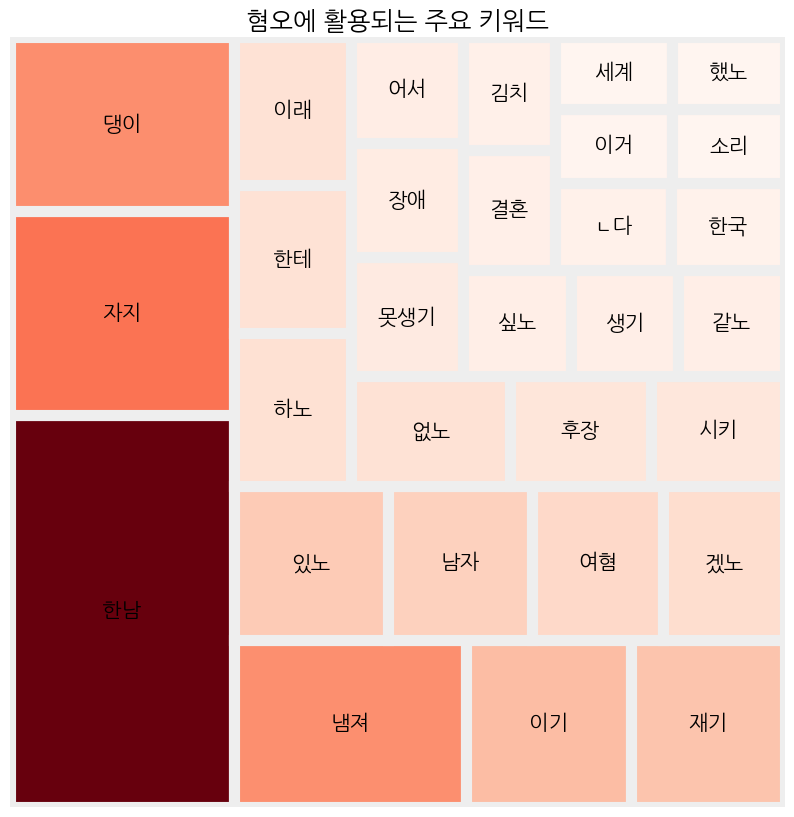

In [86]:
plot_x(0)

### 6-2. 남성

     단어       가중치
인덱스              
347  한남  6.890850
281  자지  3.586034
93   댕이  3.065344
69   냄져  3.052125
253  이기  2.174341


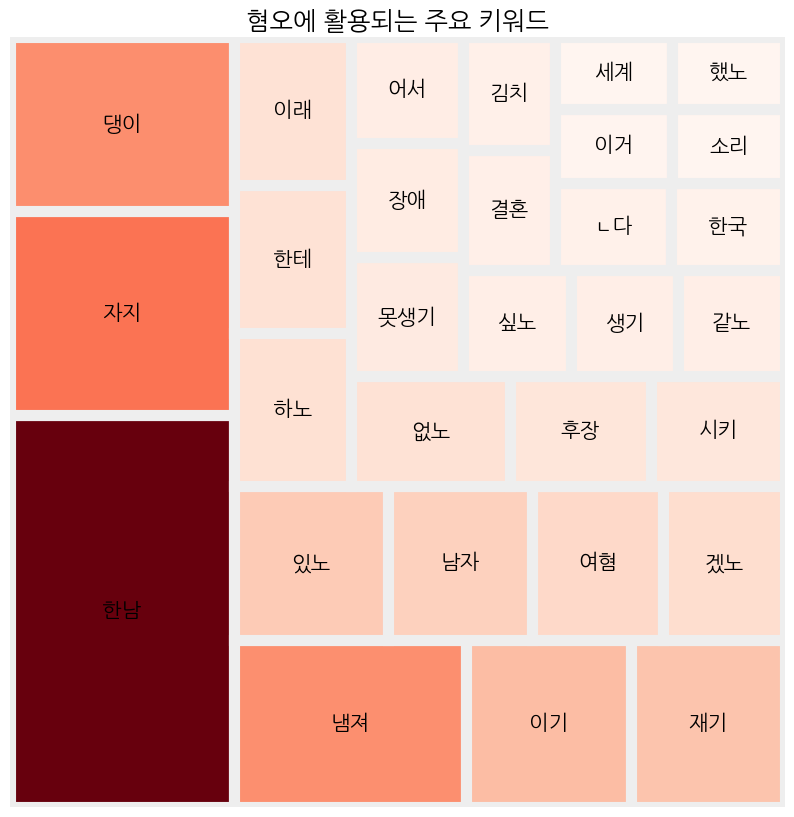

In [87]:
plot_x(1)

### 6-3. 성소수자

       단어       가중치
인덱스                
100   동성애  4.647741
101  동성애자  3.780582
23     게이  3.533253
58     꼬충  3.243192
110    똥꼬  2.903039


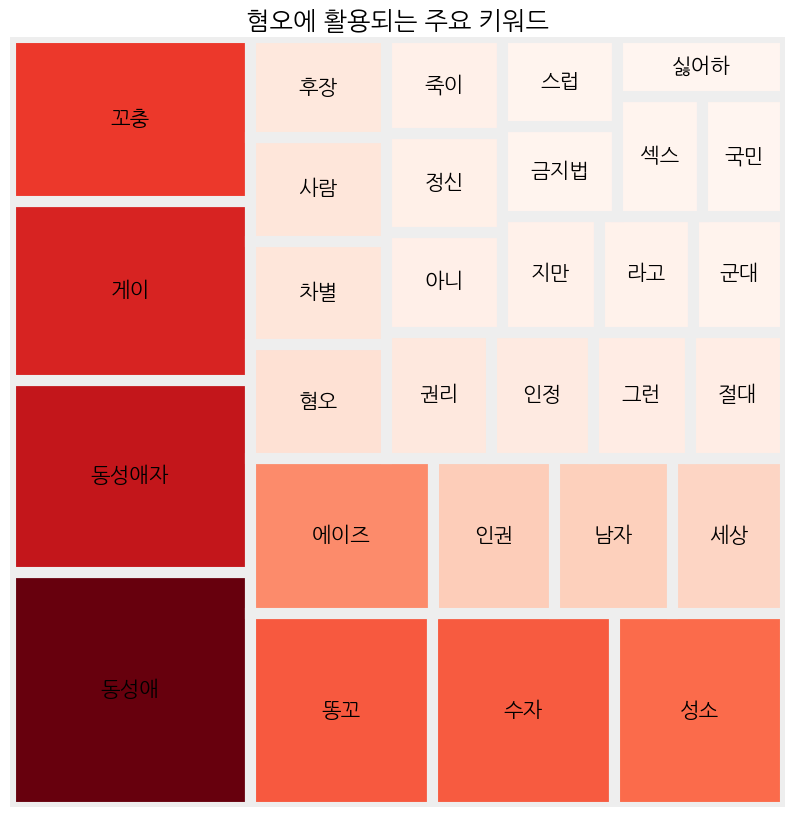

In [89]:
plot_x(2)

### 6-4. 인종/국적

      단어       가중치
인덱스               
309  조선족  3.923741
316   중국  3.445646
84   다문화  3.265852
65    난민  2.721175
333  탈북자  2.499918


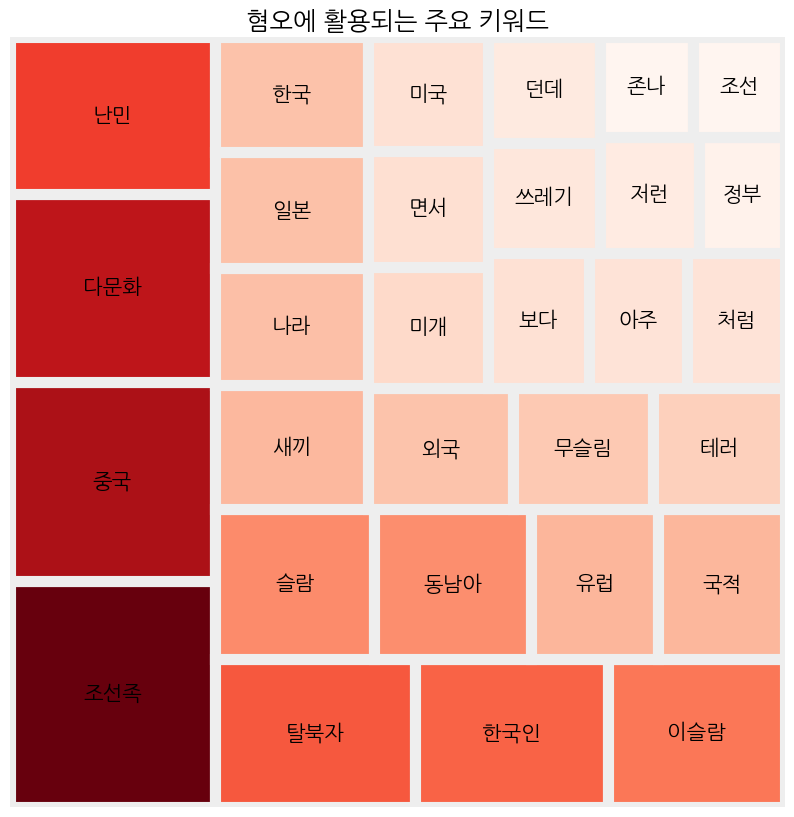

In [91]:
plot_x(3)

### 6-5. 연령

      단어       가중치
인덱스               
50    급식  4.551949
64    나이  1.496709
169   새끼  1.333710
236  올라오  1.199835
204   안되  1.141374


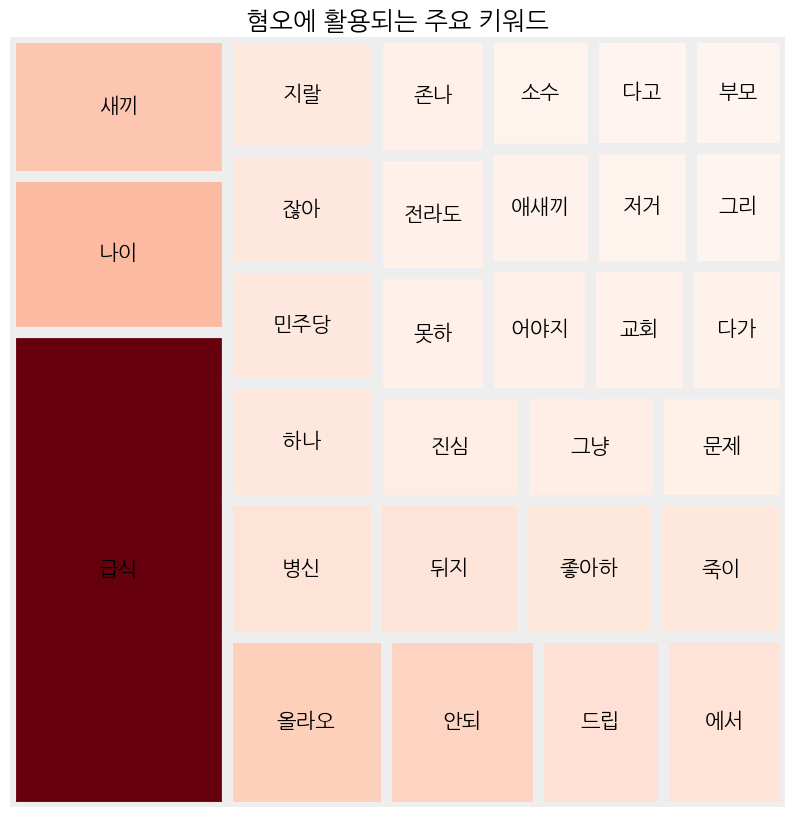

In [92]:
plot_x(4)

### 6-6. 지역

      단어       가중치
인덱스               
293  전라도  4.621232
355   홍어  4.062138
193   쌍도  3.432531
90    대구  2.994224
26   경상도  2.916873


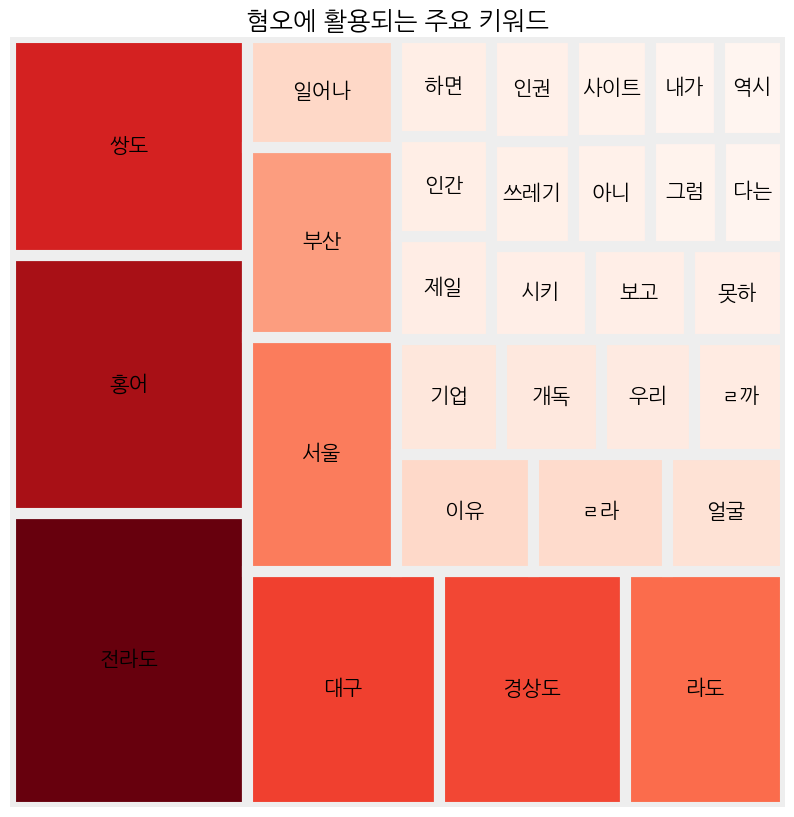

In [93]:
plot_x(5)

### 6-7. 종교

     단어       가중치
인덱스              
19   개독  3.961684
127  목사  3.946740
186  슬람  3.435409
312  종교  3.332901
31   교회  2.903494


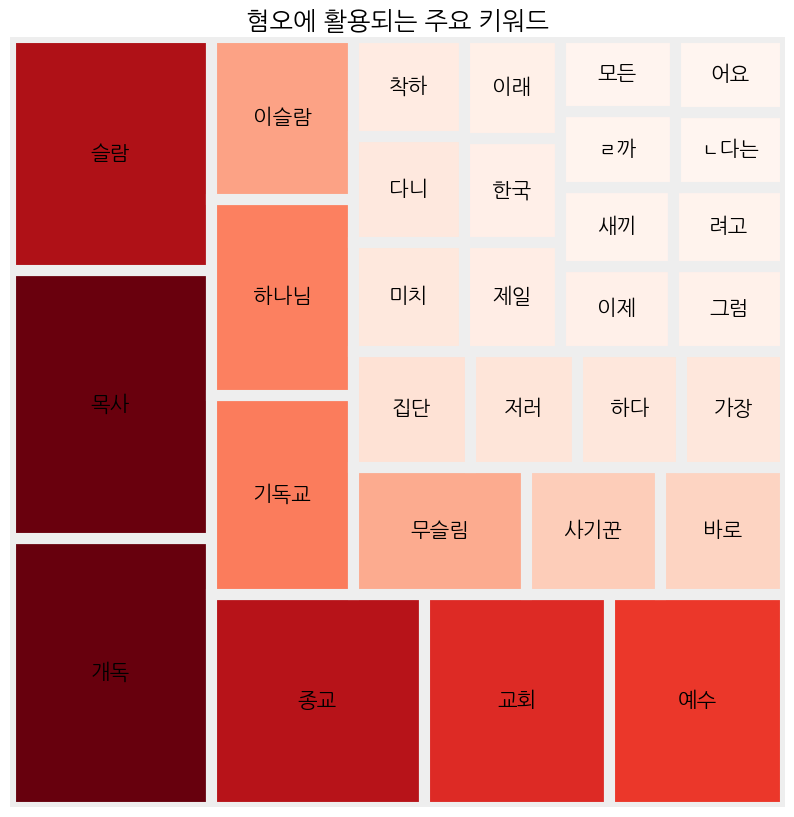

In [94]:
plot_x(6)

### 6-8. 기타 혐오

      단어       가중치
인덱스               
159  빨갱이  2.602123
325   차별  1.430154
231   역시  1.243613
184   수준  1.189651
49   금지법  1.188665


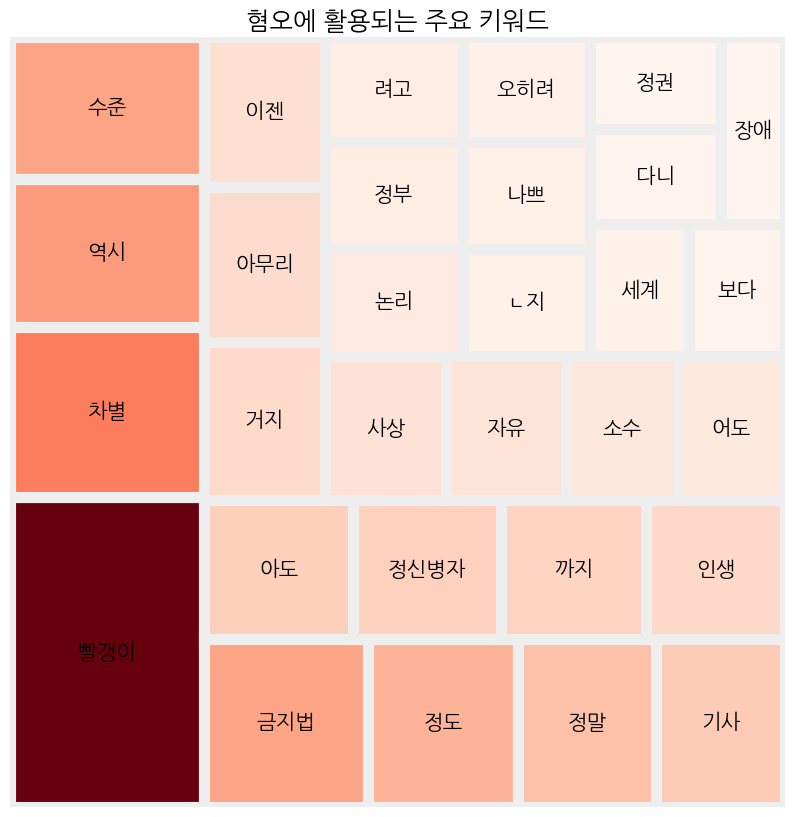

In [95]:
plot_x(7)

### 6-9. 악플/ 욕설

     단어       가중치
인덱스              
195  씨받  1.576897
297  정권  1.286304
319  지랄  1.248540
15   가지  1.229520
188  시발  1.163751


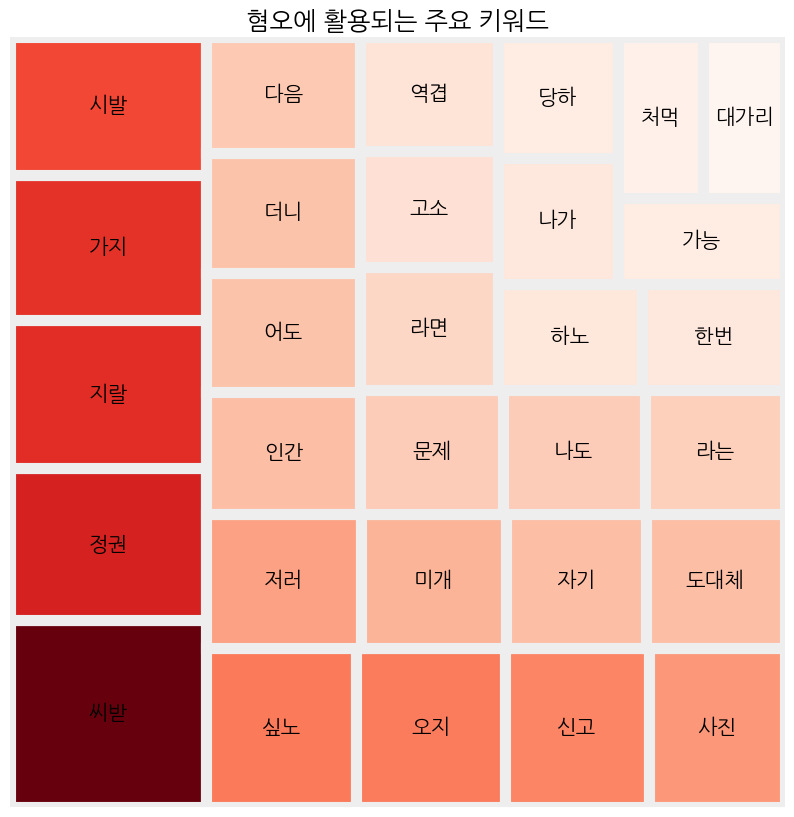

In [98]:
plot_x(8)

### 6-10. clean

      단어       가중치
인덱스               
10   ㅂ니다  1.375340
244   원래  1.253776
71    네요  1.123729
137   미국  1.089941
146   범죄  0.916220


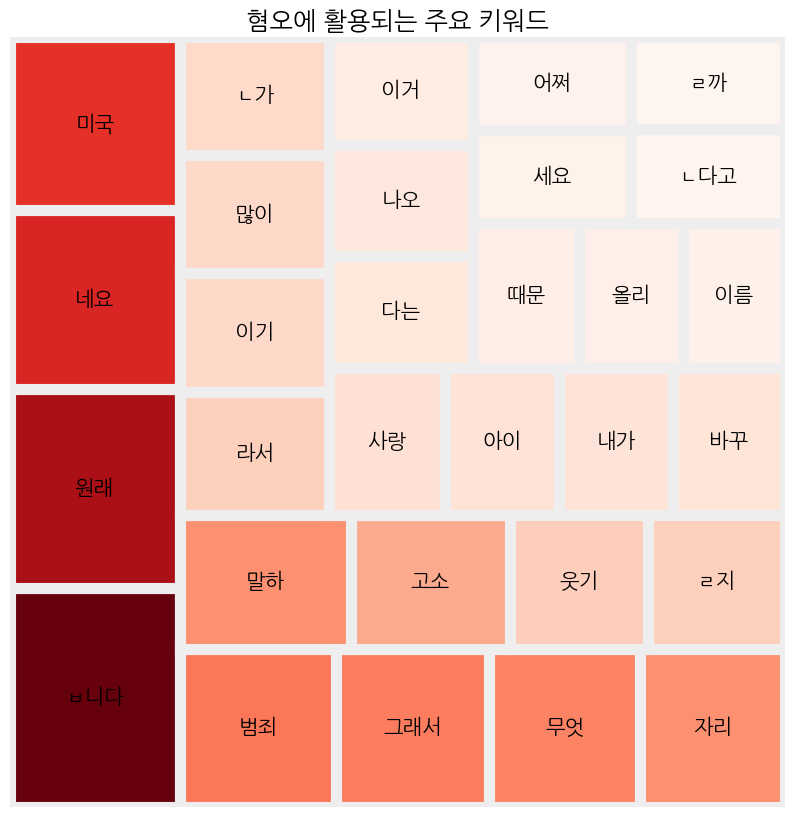

In [97]:
plot_x(9)